# Dyna Maze

This notebook contains an two methods to solve a Maze problem: Dyna-Q as a planning method, and n-step Sarsa as a multistep method. Both are run using a range of $n$ and compared.

As is usual, the design idea is to represent the environment using a struct and associated functions, while implementing the agent and the learning process simultaneously in the algorithm function. This gives enough flexibility and agility.

In [69]:
using Random
using Plots
using Statistics
using Base.Iterators

In [4]:
alpha = .1
gamma = .95
epsilon = .1
episodes = 50

50

In [5]:
mutable struct Maze
    obstacles::Array{CartesianIndex{2}}
    rows::Int32
    cols::Int32
    agent::CartesianIndex{2}
    goal::CartesianIndex{2}
end

"""
Gets a random valid agent location in the maze.
"""
function random_state(m::Maze)
    state = CartesianIndex(rand(1:m.rows), rand(1:m.cols))
    while state in m.obstacles
        state = CartesianIndex(rand(1:m.rows), rand(1:m.cols))
    end
    state
end

"""
Resets the agent location to the initial location.
"""
reset_state(m::Maze) = m.agent = CartesianIndex(3, 1)

"""
Performs an action in the Maze and returns the recieved reward and a termination flag.

# Arguments
- `action`: 1 (left), 2 (right), 3 (up) or 4 (down)
"""
function act(m::Maze, action::Int64)
    reward = 0
    episode_end = false
    new_row = m.agent[1]
    new_col = m.agent[2]
    if action == 1
        new_col = max(new_col - 1, 1)
    elseif action == 2
        new_col = min(new_col + 1, m.cols)
    elseif action == 3
        new_row = max(new_row - 1, 1)
    elseif action == 4
        new_row = min(new_row + 1, m.rows)
    end
    
    new_agent = CartesianIndex(new_row, new_col)
    if !(new_agent in m.obstacles)
        m.agent = new_agent
    end
    
    if new_agent == m.goal
        reward = 1
        episode_end = true
    end
    
    reward, episode_end
end

act

In [6]:
"""
Applies the Dyna-Q algorithm to the Maze problem. Returns the value table and the steps needed per episode.
"""
function dyna_q(m::Maze, actions, n::Int64, episodes::Int64; gamma=gamma, alpha=alpha, epsilon=epsilon)
    num_actions = length(actions)
    values = zeros(m.rows, m.cols, num_actions)
    model = fill((0, CartesianIndex(0, 0)), m.rows, m.cols, num_actions)
    
    steps = []
    for episode in 1:episodes
        reset_state(m)
        step = 0
        episode_end = false
        while !episode_end
            step += 1
            state = m.agent
            explore = rand() < epsilon
            if explore
                action = rand(actions)
            else
                action = rand(findall(x -> x == maximum(values[state, :]), values[state, :]))
            end
            reward, episode_end = act(m, action)
            state_new = m.agent
            values[state, action] += alpha * (reward + gamma * maximum(values[state_new, :]) - values[state, action])
            model[state, action] = (reward, state_new)
            for _ in 1:n
                state = random_state(m)
                taken_actions = [action for (action, tup) in enumerate(model[state, :]) if tup[2] != CartesianIndex(0, 0)]
                if length(taken_actions) <= 0
                    continue
                end
                action = rand(taken_actions)
                reward, state_new = model[state, action]
                values[state, action] += alpha * (reward + gamma * maximum(values[state_new, :]) - values[state, action])
            end
        end
        push!(steps, step)
    end
    
    values, steps
end

dyna_q

In [29]:
"""
Applies the n-step Sarsa algorithm to the Maze problem. Returns the value table and the steps needed per episode.
"""
function nstep_sarsa(m::Maze, actions, n::Int64, episodes::Int64; gamma=gamma, alpha=alpha, epsilon=epsilon)
    num_actions = length(actions)
    values = zeros(m.rows, m.cols, num_actions)
    
    steps = []
    for episode in 1:episodes
        reset_state(m)
        step = 0
        episode_end = false
        state = m.agent
        explore = rand() < epsilon
        if explore
            action = rand(actions)
        else
            action = rand(findall(x -> x == maximum(values[state, :]), values[state, :]))
        end
        states = [state]
        actions = [action]
        rewards = []
        T = typemax(Int64)
        tau = 0
        while tau != T - 1
            step += 1
            if step < T
                reward, episode_end = act(m, action)
                state = m.agent
                push!(rewards, reward)
                push!(states, state)
                if episode_end
                    T = step + 1
                    push!(steps, step)
                else
                    explore = rand() < epsilon
                    if explore
                        action = rand(actions)
                    else
                        action = rand(findall(x -> x == maximum(values[state, :]), values[state, :]))
                    end
                    push!(actions, action)
                end
            end
            tau = step - n + 1
            if tau >= 1
                return_step = min(tau + n, T)
                gammas = cumprod(fill(gamma, return_step - tau))
                G = sum(rewards[tau:return_step - 1] .* gammas)
                G += tau + n < T ? gamma ^ n * values[states[tau + n], actions[tau + n]] : 0
                values[states[tau], actions[tau]] += alpha * (G - values[states[tau], actions[tau]])
            end
        end
    end
    
    values, steps
end

nstep_sarsa

In [8]:
rows = 6
cols = 9
obstacles = [CartesianIndex(2, 3) CartesianIndex(3, 3) CartesianIndex(4, 3) CartesianIndex(5, 6) CartesianIndex(1, 8) CartesianIndex(2, 8) CartesianIndex(3, 8)]
agent = CartesianIndex(3, 1)
goal = CartesianIndex(1, 9)
maze = Maze(obstacles, rows, cols, agent, goal)
actions = 1:4

1:4

In [115]:
dyna_q(maze, actions, 50, episodes)

([0.487405125278407 0.48736536697388333 … 0.0 0.0; 0.46244071194544834 0.46285262732434523 … 0.0 0.9499996270291059; … ; 0.48766136601098775 0.4876412310704466 … 0.7350917207024302 0.7737809356001546; 0.5129577990715315 0.5129695387179294 … 0.698337202428757 0.7350918862289599]

[0.5132126949286725 0.5403415354425615 … 0.0 0.0; 0.4872849098708362 0.48734536839362025 … 0.0 0.9499999915973205; … ; 0.5133359507627413 0.5403567202652769 … 0.8145062432218786 0.8145062498523896; 0.5402207957314521 0.5687434772120356 … 0.7737809366577034 0.7737809365041103]

[0.48732363235395093 0.5132797711794135 … 0.0 0.0; 0.4874143414549346 0.5132528181013459 … 0.0 0.9999999999999996; … ; 0.0 0.4876288183177165 … 0.8145062494634335 0.8573749999910042; 0.48762985795225516 0.5133253059607066 … 0.7737809361186816 0.814506249891616]

[0.4626808999363912 0.48739862152418656 … 0.0 0.0; 0.44001763631616503 0.46303164096874194 … 0.0 0.9024999999967149; … ; 0.5130263585474414 0.540193056132697 … 0.7350918732073838 

In [46]:
nstep_sarsa(maze, actions, 50, episodes)

([0.0 0.00032040606573274837 … 0.0 0.0; 0.0 0.034579502888995084 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.24175335012362115; 0.0 0.0 … 0.0 0.0]

[0.0005724412495385739 0.0004069885988482456 … 0.0 0.0; 0.0 0.0002379038223398807 … 0.0 0.0; … ; 0.2937391328546415 0.0007636375286736794 … 0.0 0.0; 0.04780491125172512 0.3240758559112854 … 0.0 0.0]

[0.00021835921149467992 5.648619162475058e-5 … 0.0 0.0; 0.00035489272198213195 0.0002772304887059026 … 0.0 0.9451039135530457; … ; 0.0001555673462370717 0.0017556825868203804 … 0.44912111834823487 0.0; 0.0 0.0 … 0.0 0.0]

[1.9314693547789754e-5 0.00033078733287868564 … 0.0 0.0; 0.05430460080807103 0.0 … 0.0 0.0857375; … ; 0.04542321187111694 0.30911261646190075 … 0.0 0.0; 0.0 0.029198902433877228 … 0.0 0.0], Any[2373, 146, 84, 472, 147, 125, 165, 155, 144, 105  …  26, 24, 25, 25, 37, 24, 22, 22, 24, 24])

In [32]:
ns = [0 5 50]

1×3 Array{Int64,2}:
 0  5  50

In [49]:
"""
Runs the experiment multiple times for different `n` and returns the resulting steps needed to reach the goal.
"""
function run_experiment(n; method=dyna_q, runs=30)
    Random.seed!(1700)
    steps_per_episode = zeros(runs, episodes)

    for run in 1:runs
        _, steps = method(maze, actions, n, episodes)
        steps_per_episode[run, :] = steps
    end
    steps_per_episode
end

steps_per_actions = []
for n in ns
    steps_per_episode = run_experiment(n)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_actions, avg_steps[2:length(avg_steps)])
end

run_experiment

## Figure 8.2

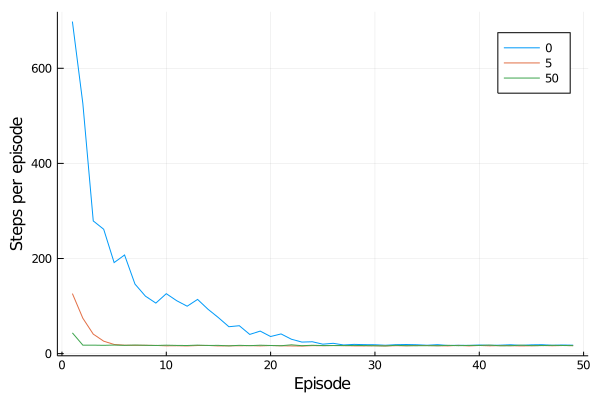

In [48]:
plot(
    steps_per_actions,
    label = map(string, ns),
    xlab = "Episode",
    ylab = "Steps per episode"
)

The graph is noticably smoother than in the book. The first episode is ommitted, as in the book.

In [63]:
ns_sarsa = [1 5 50]
steps_per_actions_sarsa = []
for n in ns_sarsa
    steps_per_episode = run_experiment(n; method=nstep_sarsa, runs=10)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_actions_sarsa, avg_steps[2:length(avg_steps)])
end

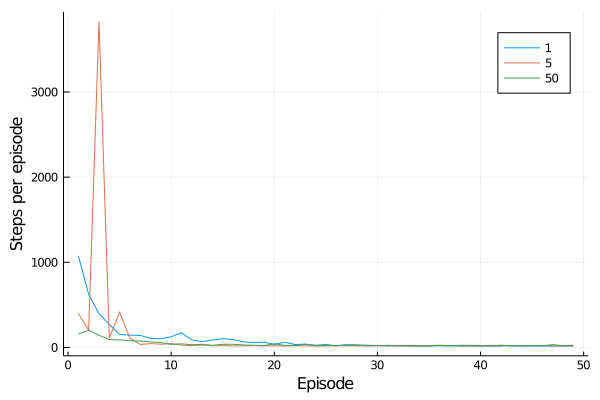

In [64]:
plot(
    steps_per_actions_sarsa,
    label = ns_sarsa,
    xlab = "Episode",
    ylab = "Steps per episode"
)

The above graph shows the performance of n-step Sarsa over a similar range of $n$. The experiment was conducted only over 10 runs, as more runs simply took way too long. It can be seen that performance is proportional to the magnitude of $n$, similar to Dyna-Q. 

There is an intriguing spike in 5-step Sarsa, which is consistent across multiple experiments. It is hard to say how this spike is caused and why it does not appear in 1-step Sarsa. Maybe the 5 steps paths are too short, so it easily breaks towards another path after initial optimizing...

In [80]:
steps_per_episode = run_experiment(50; method=nstep_sarsa, runs=20)
avg_steps = transpose(mean(steps_per_episode, dims=1))
steps_per_actions_sarsa_best = avg_steps[2:length(avg_steps)];

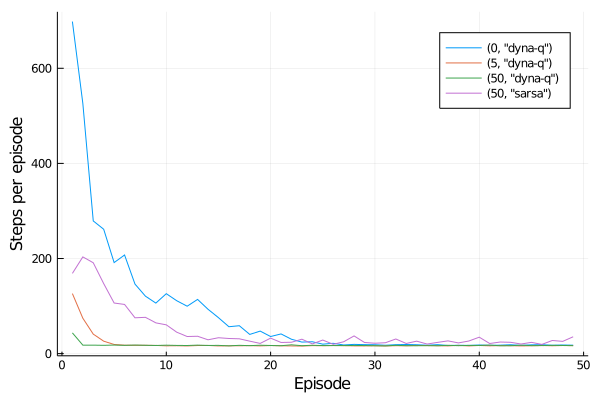

In [90]:
labels = hcat(map(x -> (x, "dyna-q"), ns), [(50, "sarsa")])

plot(
    vcat(steps_per_actions, [steps_per_actions_sarsa_best]),
    label = labels,
    xlab = "Episode",
    ylab = "Steps per episode"
)

This result plot compares the performance of n-step Sarsa to Dyna-Q. The performance is only averged over 20 runs, because it took too long otherwise. Obviously, n-step Sarsa is better than 0-step Dyna-Q, but it is noticably worse than 5 and 50-step Dyna-Q. Note, however, that the planning steps are not included in the step calculation. This is likely fair, since the planning could happen concurrent to the direct RL steps anyway.

What is interesting is that the steps needed by n-step Sarsa actually increase in the initial episodes, until they peak and decrease. Also, it might be surprising just by how much 50-step Sarsa is outperformed by 5-step Dyna-Q alone. This shows that planning is clearly necessary and improves RL agents drastically.